In [1]:
import os
import copy
import time

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets 

import torchvision.transforms as transforms
import pandas as pd
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts,ExponentialLR
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold

import zorch


### 读取数据集进行onehot编码

In [2]:
#标签和类别数进行对应
train = pd.read_csv("/kaggle/input/classify-leaves/train.csv")
labels = list(pd.read_csv("/kaggle/input/classify-leaves/train.csv")['label'])


# 标签去重
labels_unique = list(set(list(labels))) #list index--labels
label_nums = []
for i in range(len(labels)):
    label_nums.append(labels_unique.index(labels[i]))
# onehot编码
train['number'] = label_nums

# train.to_csv("./train_num_label.csv", index = 0) #记录对应关系


In [3]:
test = pd.read_csv("/kaggle/input/classify-leaves/test.csv")

### 使用sklearn. model_selection的train_test_split函数进行数据集的划分
`train_test_split` 函数是用于将数据集划分为训练集和测试集的函数，通常用于机器学习任务中。这个函数的参数如下：

- `*arrays`：要划分的原始数据集。可以是一个数组（如特征数据）或多个数组（如特征数据和标签数据）。你可以传入任意数量的数组，这些数组会按照相同的行索引进行划分。
  
- `test_size`：测试集的大小。可以是整数（表示样本数量）或浮点数（表示比例）。例如，`test_size=0.2` 表示将数据集的 20% 分配给测试集，而训练集则是剩下的部分。默认值为 `None`，表示测试集的大小由 `train_size` 参数决定。

- `train_size`：训练集的大小。可以是整数（表示样本数量）或浮点数（表示比例）。如果指定了 `train_size`，那么 `test_size` 就会被忽略。例如，`train_size=0.8` 表示将数据集的 80% 分配给训练集，而测试集则是剩下的部分。

- `random_state`：随机种子，用于控制划分过程的随机性。指定一个固定的随机种子可以保证多次运行时得到相同的划分结果。

- `shuffle`：是否在划分之前对数据进行随机洗牌。默认值为 `True`，表示在划分之前进行随机洗牌。

- `stratify`：如果指定了这个参数，并且它是一个数组或者 Series，那么划分的过程将会按照这个数组或 Series 中的类别比例进行分层抽样。这对于类别不平衡的数据集非常有用，确保训练集和测试集中各类别的比例保持一致。默认值为 `None`，表示不进行分层抽样。

这个函数的返回值通常是一个元组，包含划分后的训练集和测试集。

In [4]:
train_data,eval_data = train_test_split(train,test_size=0.2,stratify=train['number'])

###  自定义Dataset

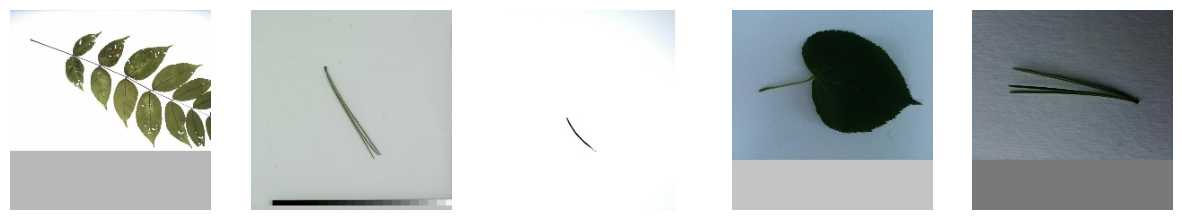

In [5]:

class Leaf_Dataset(Dataset):
    '''
    树叶数据集的训练集 自定义Dataset
    '''
    def __init__(self, train_csv, transform = None, test = False):
        '''
        train_path : 传入记录图像路径及其标号的csv文件
        transform : 对图像进行的变换
        '''
        super().__init__()
        self.train_csv = train_csv
        self.image_path = list(self.train_csv['image']) #图像所在地址记录
        self.test = test
        if not self.test:
            self.label_nums = list(self.train_csv['number']) #图像的标号记录
        self.transform = transform
        
    def __getitem__(self, idx):
        '''
        idx : 所需要获取的图像的索引
        return : image， label
        '''
        image = cv2.imread(os.path.join("/kaggle/input/classify-leaves", self.image_path[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = Image.open(os.path.join("/kaggle/input/classify-leaves", self.image_path[idx]))
        if(self.transform != None):
            image = self.transform(image = image)['image']
        if not self.test:
            label = self.label_nums[idx]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.image_path)

# 展示图片
from zorch import tools
train_test = Leaf_Dataset(train_data)
train_DataLoader= DataLoader(train_test,batch_size=64,shuffle=True,num_workers=4)
tools.display_data(train_DataLoader,[])


### 数据增强

In [6]:
transforms_train = albumentations.Compose(
    [
        albumentations.Resize(320, 320),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.Rotate(limit=180, p=0.7),
        albumentations.RandomBrightnessContrast(),
        albumentations.ShiftScaleRotate(
            shift_limit=0.25, scale_limit=0.1, rotate_limit=0
        ),
        albumentations.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
            max_pixel_value=255.0, always_apply=True
        ),
        ToTensorV2(p=1.0),
    ]
)
transforms_test = albumentations.Compose(
        [
            albumentations.Resize(320, 320),
            albumentations.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
                max_pixel_value=255.0, always_apply=True
            ),
            ToTensorV2(p=1.0)
        ]
    )

### 模型训练主流程

In [7]:
def train_model(train_loader, valid_loader, device = torch.device("cuda:0")):
    # 加载一个预训练模型进行微调
    net = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
    in_features = net.fc.in_features
    net.fc = nn.Linear(in_features, 176)
    net = net.to(device)

    epoch = 30
    best_epoch = 0
    best_score = 0.0
    best_model_state = None
    early_stopping_round = 3
    losses = []

    # 定义优化，损失函数和学习率调度器
    optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=1e-5)
    loss = nn.CrossEntropyLoss(reduction='mean')
    scheduler = ExponentialLR(optimizer, gamma=0.9,verbose=True)
    for i in range(epoch):
        acc = 0
        loss_sum = 0
        net.train()
        # 训练模型
        for x, y in tqdm(train_loader):
            x = torch.as_tensor(x, dtype=torch.float)
            x = x.to(device)
            y = y.to(device)
            y_hat = net(x)
            loss_temp = loss(y_hat, y)
            loss_sum += loss_temp
            optimizer.zero_grad()
            loss_temp.backward()
            optimizer.step()
#             scheduler.step()
            acc += torch.sum(y_hat.argmax(dim=1).type(y.dtype) == y)
        scheduler.step()
        losses.append(loss_sum.cpu().detach().numpy() / len(train_loader))
        print( "epoch: ", i, "loss=", loss_sum.item(), "训练集准确度=",(acc/(len(train_loader)*train_loader.batch_size)).item(),end="")
        test_acc = 0
        net.eval()
        # 验证模型
        for x, y in tqdm(valid_loader):
            x = x.to(device)
            x = torch.as_tensor(x, dtype=torch.float)
            y = y.to(device)
            y_hat = net(x)
            test_acc += torch.sum(y_hat.argmax(dim=1).type(y.dtype) == y)
        print("验证集准确度", (test_acc / (len(valid_loader)*valid_loader.batch_size)).item())
        
        #  保存最佳模型
        if test_acc > best_score:
            best_model_state = copy.deepcopy(net.state_dict())
            best_score = test_acc
            best_epoch = i
            print('best epoch save!')
        # 早停, 当验证集准确度连续3个epoch没有提升时停止训练
        if i - best_epoch >= early_stopping_round:
            break
    
    #  验证最佳模型
    #  训练，测试，验证集
    net.load_state_dict(best_model_state)
    testset = Leaf_Dataset(test, transform = transforms_test,test = True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, drop_last=False)
    device = torch.device("cuda:0")
    predictions = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.to(device)
            x = torch.as_tensor(x, dtype=torch.float)
            y_hat = net(x)
            predict = torch.argmax(y_hat,dim=1).reshape(-1)
            predict = list(predict.cpu().detach().numpy())
            predictions.extend(predict)
    return predictions

# 创建一个空的 DataFrame 用于存储每个折叠的预测结果
prediction_df = pd.DataFrame()
# 使用分层 K 折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)
# 遍历每个折叠
for fold_n, (trn_idx, val_idx) in enumerate(skf.split(train, train['number'])):
    print(f'fold {fold_n} training...')
    # 获取训练集和验证集的索引
    train_data = train.iloc[trn_idx]
    eval_data = train.iloc[val_idx]
    # 创建训练集和验证集的数据集对象，并进行数据转换
    trainset = Leaf_Dataset(train_data, transform=transforms_train)
    evalset = Leaf_Dataset(eval_data, transform=transforms_test)
    # 创建训练集和验证集的数据加载器
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=48, shuffle=True, drop_last=False)
    eval_loader = torch.utils.data.DataLoader(evalset, batch_size=48, shuffle=False, drop_last=False)
    # 调用 train_model 函数进行模型训练和验证，并获取验证集的预测结果
    predictions = train_model(train_loader, eval_loader)
    # 将每个折叠的预测结果添加到 prediction_df 中
    prediction_df[f'fold_{fold_n}'] = predictions

    

fold 0 training...
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/306 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# 将每个折叠中的预测结果整合起来，找出每行（每个样本）中出现次数最多的预测结果，并转换为整数类型
all_predictions = list(prediction_df.mode(axis=1)[0].astype(int))

# 创建一个空列表用于存储最终的预测标签
predict_label = []

# 将整数类型的预测结果映射回原始的类别标签
for i in range(len(all_predictions)):
    predict_label.append(labels_unique[all_predictions[i]])

# 读取测试数据集的标签文件
submission = pd.read_csv("/kaggle/input/classify-leaves/test.csv")

# 将预测结果添加到测试数据集中，并保存为 CSV 文件
submission["label"] = pd.Series(predict_label)
submission.to_csv("result.csv", index=False)


In [ ]:
submission